In [7]:
cd("/Users/elfflorin/Documents/Projects/julia.hw/jpie-v0.4")
include("setup.jl")
using brml


Available Demos:

demoBurglar.jl
demoBurglarDictPot.jl
demoBurglarSimple.jl
demoChainIndepRational.jl
demoHMMburglar.jl
demoHMMinferenceFG.jl
demoHMMinferenceSimple.jl
demoHMMlearn.jl
demoMaxProd.jl
demoPlotDAG.jl
demoPotLogArray.jl
demoSumProd.jl
demoSumProdStandardiseVariables.jl


In [8]:
Gx = 5 # two dimensional grid size
Gy = 5  
H = Gx * Gy # number of states on grid

25

In [9]:
# matrix representing the possible states of the system
st = reshape(1:H, Gx, Gy) # assign each grid point a state

5x5 Array{Int64,2}:
 1   6  11  16  21
 2   7  12  17  22
 3   8  13  18  23
 4   9  14  19  24
 5  10  15  20  25

In [10]:
# make a deterministic state transition matrix HxH on a 2D grid:
phgh = zeros(H, H) # transition from state j to state i  
for x = 1:Gx
    for y = 1:Gy
        # from the current state-cell (j coord in state transition matrix)
        # to next state-cell on (i coord in state transition matrix):
        #   the next row, same column
        if validgridposition(x + 1, y, Gx, Gy) # sample for x = 1, y = 2
            phgh[st[x + 1, y], st[x, y]] = 1 # 2,2=7  1,2=6
        end
        #   the previous row, same column
        if validgridposition(x - 1, y, Gx, Gy)
            phgh[st[x - 1, y], st[x, y]] = 1 # 0,2  1,2
        end
        #   the same row, next column
        if validgridposition(x, y + 1, Gx, Gy)
            phgh[st[x, y + 1], st[x, y]] = 1 # 1,3=11 1,2=6
        end
        #   the same row, previous column
        if validgridposition(x, y - 1, Gx, Gy)
            phgh[st[x, y - 1], st[x, y]] = 1 # 1,1=1 1,2=6
        end
    end
end
# conditional distribution from state transition matrix
phghm = condp(phgh) # matrix with sum(phghm, 1) = 1 with phghm[i, j] = p(hg=i | hm=j)
ph1=condp(ones(H,1)) # initialise probabilities for the states of the hidden variable at timestep 1
pvgh=zeros(4,H) # initialise emision matrix

4x25 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [11]:
pv1gh = 0.01 * ones(1,H); r = randperm(H); pv1gh[r[1:10]] = 0.9; # Creaks in 10 randomly chosen cells
pv2gh = 0.01 * ones(1,H); r = randperm(H); pv2gh[r[1:10]] = 0.9; # Bumps in 10 randomly chosen cells

0.9

In [12]:
setNoTicksLabels(x) = function(axesfig)
    PyPlot.setp(axesfig[:get_xticklines](), visible=false)
    PyPlot.setp(axesfig[:get_xticklabels](), visible=false)
    PyPlot.setp(axesfig[:get_yticklines](), visible=false)
    PyPlot.setp(axesfig[:get_yticklabels](), visible=false) 
end

setNoTicksLabels (generic function with 1 method)

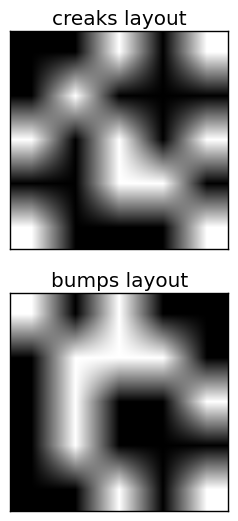

2-element Array{Array{Any,1},1}:
 Any[nothing,nothing,nothing,nothing,nothing,nothing,nothing]
 Any[nothing,nothing,nothing,nothing,nothing,nothing,nothing]

In [13]:
PyPlot.figure()
axc = PyPlot.subplot(2, 1, 1)
axc[:set_title]("creaks layout")
PyPlot.imshow(reshape(pv1gh, Gx, Gy), cmap="bone"); 
axb = PyPlot.subplot(2, 1, 2)
axb[:set_title]("bumps layout")
PyPlot.imshow(reshape(pv2gh, Gx, Gy), cmap="bone");
map([axb, axc]) do axesfig
    PyPlot.setp(axesfig[:get_xticklines](), visible=false)
    PyPlot.setp(axesfig[:get_xticklabels](), visible=false)
    PyPlot.setp(axesfig[:get_yticklines](), visible=false)
    PyPlot.setp(axesfig[:get_yticklabels](), visible=false) 
end

In [14]:
# Form the joint distribution p(v|h)=p(v1|h)p(v2|h) 
# v = (v1, v2) and v1 and v2 are independent given h
vv = zeros(4, 2)
for i = 1:4
    pvgh[1, :] =  pv1gh .* pv2gh; vv[1, :] = [1 1]; # p(v1=1|h)*p(v2=1|h)
    pvgh[2, :] =  pv1gh.*(1-pv2gh); vv[2, :] = [1 2]; # p(v1=1|h)*p(v2=1|h)
    pvgh[3, :] =  (1-pv1gh).*pv2gh; vv[3, :] = [2 1]; # p(v1=1|h)*p(v2=1|h)
    pvgh[4, :] =  (1-pv1gh).*(1-pv2gh); vv[4, :] = [2 2]; # p(v1=1|h)*p(v2=1|h)
end

In [15]:
# draw some random samples:
T=10 
h = zeros(Integer, 1, T) # holds the state value for the hidden variable at a specific timestep
v = zeros(Integer, 1, T) # holds the state value for the visible variable at a specific timestep

h[1]=randgen(ph1) # initialize the hidden variable @t=1 with a random state based on ph1 distribution
v[1]=randgen(pvgh[:, h[1]]) # initialize the visible variable @t=1 with a random state based on pvgh( vg | h@t=1)

for t=2:T
    h[t]=randgen(phghm[:, h[t-1]]) # set the hidden variable state @t based on h@t-1 using the transition matrix
    v[t]=randgen(pvgh[:, h[t]]) # set the visible variable state @t based on h@t using the emission matrix
end

In [16]:
# Perform inference based on the observed v:
(alpha, loglik) = HMMforward(v, phghm, ph1, pvgh) # filtering
phtgV1t = alpha # filtered posterior - infer the current hidden state p(ht | v_1:t)

25x10 Array{Float64,2}:
 0.000172381  0.00493863   0.000382748  …  4.57822e-8   0.0749453  
 0.00170657   0.00266054   0.00955024      0.0871667    1.67884e-9 
 0.153592     5.75275e-6   0.0386663       1.12671e-7   0.000410364
 0.00170657   0.00617537   0.157457        0.354538     3.50322e-8 
 0.153592     5.54279e-6   0.0012199       9.46335e-8   0.000570301
 0.00170657   0.000440652  0.0101758    …  0.00497924   6.84182e-10
 0.0155143    0.000536643  0.0057617       5.90524e-9   0.00834689 
 0.000172381  0.40594      0.015971        0.0104604    5.95704e-6 
 0.000172381  0.171804     0.0388304       4.82919e-6   0.518967   
 0.00170657   0.00370882   0.367142        0.270222     7.70199e-8 
 0.0155143    0.000517747  0.00198231   …  2.60651e-9   0.00292298 
 0.000172381  0.20615      0.00077701      0.00214441   2.96739e-6 
 0.153592     0.000189568  0.0570589       4.78032e-6   6.43617e-5 
 0.153592     0.000374628  0.0371196       0.00729193   1.41895e-8 
 0.000172381  0.171617  

In [17]:
function HMMgamma(alpha,phghm)
    #HMMGAMMA HMM Posterior smoothing using the Rauch-Tung-Striebel correction method
    # gamma=HMMbackward(alpha,phghm)
    #
    # Inputs:
    # alpha : alpha forward messages (see HMMforward.m)
    # phghm : transition distribution in a matrix
    #
    # Outputs: gamma(i,t) is p(h(t)=i|v(1:T))
    # See also HMMbackward.m, HMMviterbi.m, demoHMMinference.m

    T=size(alpha,2); H=size(phghm, 1);
    # gamma recursion
    gamma=zeros(size(alpha))
    gamma[:,T]=alpha[:,T];
    for t=T-1:-1:1
        phghp=condp(phghm'.*repmat(alpha[:,t],1,H));
        gamma[:,t]=condp(phghp*gamma[:,t+1]);
    end

    if 1==0 # gamma recursion: More human readable
        gamma[:, T]=alpha[:, T]./sum(alpha[:, T])
        for t = T-1:-1:1
            phghp=phghm'.*repmat(alpha[:,t],1,H)
            phghp=phghp./repmat(sum(phghp, 1),H,1)
            gamma[:,t]=phghp*gamma[:,t+1]
        end
    end
    return gamma
end

HMMgamma (generic function with 1 method)

In [18]:
phtgV1T = HMMgamma(alpha, phghm) # Smoothed Burglar distribution
maxstate, logprob = HMMviterbi(v, phghm, ph1, pvgh) # Most likely Burglar path

(
1x10 Array{Int64,2}:
 14  15  10  5  10  15  10  5  4  9,

-13.356006075012617)

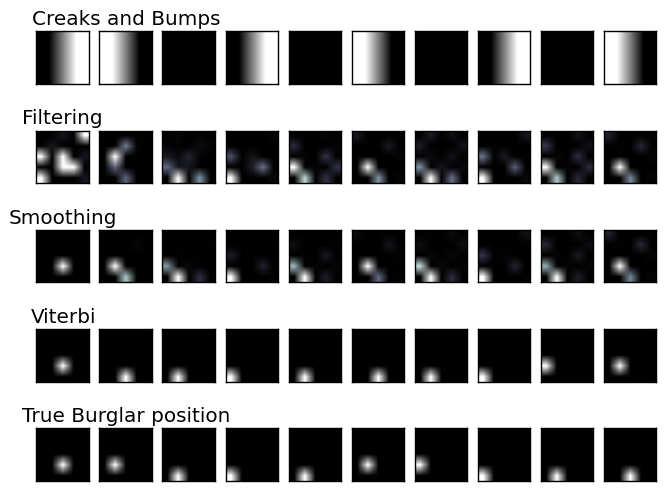

In [19]:
PyPlot.figure()
for t = 1:T
    axg = PyPlot.subplot(5, T, t); PyPlot.imshow(repmat(vv[v[t], :], 2, 1), cmap="bone");
    if t == 2 # used t == 1 or t == 2 for title alignment only
        axg[:set_title]("Creaks and Bumps")
    end
    # add Filtering data row of T images from the previous row offset
    axf = PyPlot.subplot(5, T, T+t);  PyPlot.imshow(reshape(phtgV1t[:, t], Gx, Gy), cmap="bone");
    if t == 1 
        axf[:set_title]("Filtering")
    end
    # add Smoothing data row of T images from the previous row offset
    axs = PyPlot.subplot(5, T, 2*T+t);  PyPlot.imshow(reshape(phtgV1T[:, t], Gx, Gy), cmap="bone");
    if t == 1 
        axs[:set_title]("Smoothing")
    end
    z=zeros(H,1); z[maxstate[t]]=1;
    # add Viterbi data row of T images from the previous row offset
    axv = PyPlot.subplot(5,T,3*T+t); PyPlot.imshow(reshape(z,Gx,Gy), cmap="bone")
    if t == 1 
        axv[:set_title]("Viterbi")
    end
    z = zeros(H,1); z[h[t]] = 1;
    # add true data row of T images from the previous row offset
    axt = PyPlot.subplot(5,T,4*T+t); PyPlot.imshow(reshape(z,Gx,Gy), cmap="bone")
    if t == 2
        axt[:set_title]("True Burglar position")
    end
    map([axg, axf, axs, axv, axt]) do axesfig
        PyPlot.setp(axesfig[:get_xticklines](), visible=false)
        PyPlot.setp(axesfig[:get_xticklabels](), visible=false)
        PyPlot.setp(axesfig[:get_yticklines](), visible=false)
        PyPlot.setp(axesfig[:get_yticklabels](), visible=false) 
    end
end